<h1><strong>CSE 555 - Introduction to Pattern Recognition</strong></h1>

<h2><strong>Programming Assignment 5 :- Generative Models</strong></h2>
<h4><strong> Jyoti Sinha</strong></h4>

In [ ]:
!pip install tensorflow==1.14

<h1>Problem(2) Variational Autoencoder</h1>

Variational Autoencoder is an autoencoder which allows to keep  good properties in its latent space by regularizing the encoding distribution during training to generate some new data. Let us try to understand it using an example. Suppose we have to generate an animal and we want some features of animal like it must have four legs and must able to swim. So, our imagination is similar to latent variable. Having those latent space we can generate the animal by sampling the animal kingdom. Latent variable basically describe our model. Without latent variable we generate our data blindly.Hence, it is a expressive model. In order to explain it properly, I am defining some notations.

NOTATIONS:

$ X $ input Data for the model
$ z $ Latent variable ie. our imagination
$ P(X) $ Probability distribution of the data
$ P(z) $ Probability distribution of latent variable
$ P(X|z) $ Probability distribution of data given latent variable
Our main goal is to model the data, hence we need to find $P(X)$. This can be done as follows:

$ P(X) = \int{P(X|z) P(z) dz}$

that is we marginalize the latent variable from joint probability distribution.

Thus, we need $P(X,z)$. The idea is to infer $ P(z) $ using $ P(z|X) $.We infer the distribution  $ P(z|x) $  using a method called Variational Inference(VI). The main idea of Variational Inference is to pose the inference by thinking it as an optimization problem. This can be acheived by modeling the true distribution $P(z|X)$ using another simplier distribution such as Gaussian, and minimize the distribution using KL divergence, which tells us difference between P and Q.

Now we have to infer $ P(z|X)$ using $Q(z|X)$ then KL divergence then formulated as follows:


$$D_{KL}[Q(z|X)∥P(z|X)] = \Sigma_z Q(z|X) log \frac{Q(z|X)}{P(z|X)}\\
                       = E[ log \frac{Q(z|X)}{P(z|X)}]\\
                       = E[log Q(z|X) - log P(z|X)]
$$

Applying Baye's rule:$$
D_{KL}[Q(z|X)∥P(z|X)] = E[log Q(z|X) - log \frac{P(X|z) P(z)}{P(X)}]
= E[log Q(z|X) − log P(X|z) − log P(z) + log P(X)]
$$
Here, the expectation is over z and P(X) doesn’t depend on z, so we could move it outside of the expectation:
$$D_{KL}[Q(z|X)∥P(z|X)] = E[log Q(z|X) − log P(X|z) − log P(z) ] + log P(X)
$$

$$D_{KL}[Q(z|X)∥P(z|X)] - log P(X)  = E[log Q(z|X) − log P(X|z) − log P(z)]
$$

The right hand side of Eq 15 can be expressed as another KL divergence by rearraging the sign:
$$D_{KL}[Q(z|X)∥P(z|X)] - log P(X)=E[log Q(z|X) - (log P(X|z) − log P(z))]$$



$$ log P(X) - D_{KL}[Q(z|X)∥P(z|X)] = E[log P(X|z) - (log Q(z|X) − log P(z))]
                                   = E[log P(X|z)] - E[log Q(z|X) - log P(z)]
$$This is the VAE objective function:$$
log P(X) - D_{KL}[Q(z|X)∥P(z|X)] = E[log P(X|z)] - D_{KL}[Q(z|X)∥P(z)]
$$




<h3>Importing Libraries</h3>

In [ ]:
#Importing Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

<h3>Importing Dataset</h3>


In [ ]:
#Importing the dataset
mnist=input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


<h3>Defining Code Unit</h3>

In [ ]:
# Defining the code units as mentioned in the problem
for code_unit in codeunit_arr:
  codeunit_arr = [2, 8, 16]
print('For code unit:', '\n'.join([str(code_unit) for code_unit in codeunit_arr]), sep='\n')



For code unit:
2
8
16


<h3>Encoder part</h3>

In [ ]:
#Intilaizing the variables
mnist_data = mnist.train.images.shape[1]
x_dim = tf.placeholder(tf.float32, shape=[None, mnist_data])
z = tf.placeholder(tf.float32, shape=[None, code_unit])

In [ ]:
def construct(size):
  input_dim = size[0]
  construct_stddev = 1. / tf.sqrt(input_dim / 2.)
  return tf.random_normal(shape=size, stddev=construct_stddev)

In [ ]:
#Caculation of Q(Z|X) ie. hidden_output(z|x_dim) in this code 
def encode(mnist_data):
  # Intial Weight and baises
  
  W1 = tf.Variable(construct([mnist_data, 256]))
  b1 = tf.Variable(tf.zeros(shape=[256]))
  
  # update the weight and baises
  W1_mu = tf.Variable(construct([256, code_unit]))
  b1_mu = tf.Variable(tf.zeros(shape=[code_unit]))

  W1_sigma = tf.Variable(construct([256, code_unit]))
  b1_sigma = tf.Variable(tf.zeros(shape=[code_unit]))

  return W1

<h3>Instantiate part</h3>

In [ ]:
def hidden_output(x_dim):
        h = tf.nn.relu(tf.matmul(x_dim, W1) + b1)
        output_mu = tf.matmul(h, W1_mu) + b1_mu
        output_var = tf.matmul(h, W1_sigma) + b1_sigma
        return output_mu, output_var

In [ ]:
def sampling(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

<h3>Decoder Part</h3>


In [ ]:
#Calculation of P(z|X) i.e P(z|x_dim)
def decode():
  Prob_W1 = tf.Variable(construct([code_unit, 256]))
  Prob_b1 = tf.Variable(tf.zeros(shape=[256]))

  Prob_W2 = tf.Variable(construct([256, mnist_data]))
  Prob_b2 = tf.Variable(tf.zeros(shape=[mnist_data]))

  return Prob_W1,Prob_b1,Prob_W2,Prob_b2



In [ ]:
def P(z):
  h = tf.nn.relu(tf.matmul(z, Prob_W1) + Prob_b1)
  logits = tf.matmul(h, Prob_W2) + Prob_b2
  prob = tf.nn.sigmoid(logits)
  return prob, logits


<h3>Instantiation</h3>


In [ ]:
# Variables intialization and declartaions
output_mu,output_var = hidden_output(x_dim)
z_sample = sampling(output_mu, output_var)
_, logits = P(z_sample)
# Sampling from random z
X_samples, _ = P(z)

<h3>Losses Calculation</h3>


In [ ]:
#Vae (Variational autoencoder loss) calculation
entropy_err = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=x_dim)
reconstruction_loss = tf.reduce_sum(entropy_err, 1)
kldiv_err = tf.exp(output_var) + output_mu**2 - 1. - output_var
kldiv_loss = 0.5 * tf.reduce_sum(kldiv_err, 1)
vae_loss = tf.reduce_mean(reconstruction_loss + kldiv_loss)
solver = tf.train.AdamOptimizer().minimize(vae_loss)


<h3> Graph Plot</h3

In [ ]:
for code_unit in codeunit_arr:
    #print("For code unit: {}".format(str(code_unit)))
    def plot(samples):
        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
        return fig

Iter: 0
Loss: 774.7



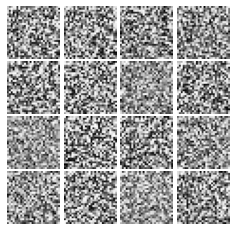

Iter: 1000
Loss: 130.2



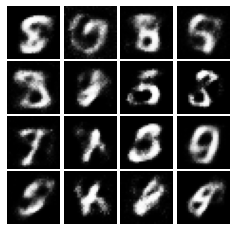

Iter: 2000
Loss: 121.6



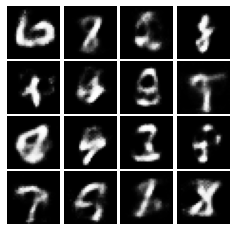

Iter: 3000
Loss: 111.6



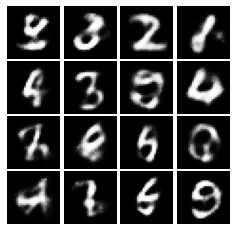

Iter: 4000
Loss: 108.7



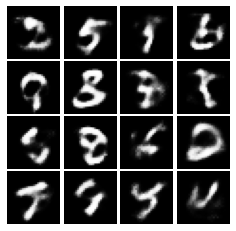

Iter: 5000
Loss: 115.2



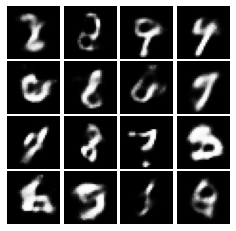

Iter: 6000
Loss: 106.3



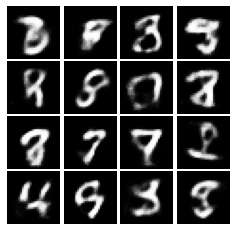

Iter: 7000
Loss: 106.5



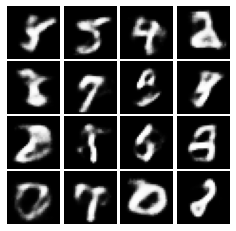

Iter: 8000
Loss: 104.7



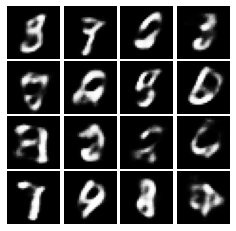

Iter: 9000
Loss: 109.4



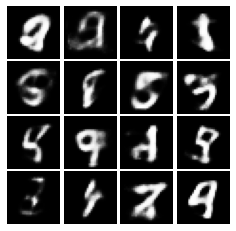

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
i = 0
for it in range(10000):
    X_mb, _ = mnist.train.next_batch(64)
  
    # elem = loss(x_dim,output_var)
    _, loss = sess.run([solver,vae_loss], feed_dict={x_dim: X_mb})
     

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

        samples = sess.run(X_samples, feed_dict={z: np.random.randn(16, code_unit)})
        fig = plot(samples)
        plt.show()
        i += 1
        plt.close(fig)

<h3>References:-</h3>

1)https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder

2)Textbook

3)Slide

4)https://blog.keras.io/building-autoencoders-in-keras.

5)https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf